# numba-rvsdg demo

This is an introduction to the use of the `numba_rvsdg` package. Here, we show how to convert Python source as Abstract Syntax Tree (AST) into a Control Flow Graph (CFG) and then into a Structured Control Flow Graph and finally back into Python source as Abstract Syntax Tree. Specifically, this demos the use of the AST -> SCFG -> AST transformer pipeline.

The code in this demo is a faithful implementation of the Algorithms described in `Bahmann2015` -- https://dl.acm.org/doi/pdf/10.1145/2693261

The transformer pipeline consists of the following steps:

* Convert Python AST into a plain CFG. (This also prunes unreachable, empty and no-op nodes (`pass` and `...` (ellipsis))).
* Apply the following transforms to go from CFG to SCFG:
  * `CLOSE_CFG` :: this will add edges and a node such that the CFG only has a single exiting node. The graph is then considered _closed_.
  * `LOOP_RESTRUCTURE` :: This will perform a type of loop rotation such that every loop has a single header, a single exiting latch and a single backedge to the header. The loop is then considered _closed_.
  * `BRANCH_RESTRUCTURE` :: This will partition the graph such that every branching flow control construct is divided into three types of `regions`. `HEAD` regions that are a linear set of instructions that conclude with a branch/jump. Two or more `BRANCH` regions that contain the code for each control flow path taken. And finally a single `TAIL` region that all `BRANCH` regions fall through to.
* Lastly we synthesize an equivalent Python program which is structurally different but behaviourally equivalent. That is to say the same input will yield the same output, (barring any stochastic programs). This program can then be run by the interpreter.

Note that some AST level rewrites were employed in order to desugar the Python `for` loop semantics into the CFG style formalism of basic blocks and edges between them.

Note also that the flow control of Python `Exceptions` is not yet handled by this pipeline (as of 2024-06-14).

In [32]:
import ast
from numba_rvsdg.core.datastructures.ast_transforms import AST2SCFGTransformer, SCFG2ASTTransformer, unparse_code
from numba_rvsdg.rendering.rendering import SCFGRenderer

def render_scfg_info_notebook(scfg):
    return SCFGRenderer(scfg).g

def compile_ast(ast_):
    exec_locals = {}
    exec(ast.unparse(ast_), {}, exec_locals)
    transformed = exec_locals["transformed_function"]
    return transformed

Let's begin with a simple branching function. This will show the basics of the BRANCH_RESTRUCTURE.

In [10]:
def branch(b: int):
    if b:
        r = 1
    else:
        r = 2
    return r

In [11]:
scfg = AST2SCFGTransformer(branch).transform_to_SCFG()

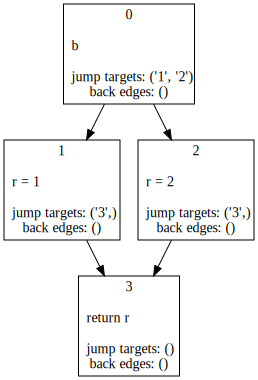

In [12]:
render_scfg_info_notebook(scfg)

In [13]:
scfg.restructure()

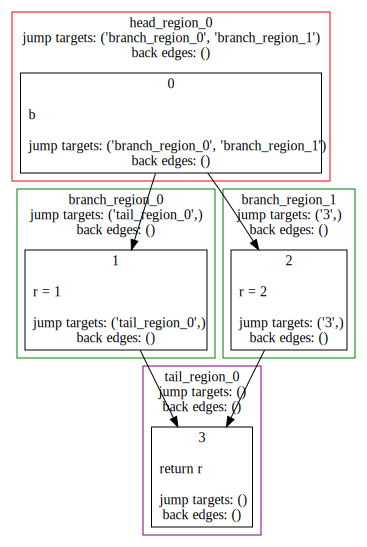

In [14]:
render_scfg_info_notebook(scfg)

Now, to complete the pipeline, let's synthesize some Python code from this structure.

In [29]:
original_ast = unparse_code(branch)[0]
transformed_ast  = SCFG2ASTTransformer().transform(original=original_ast, scfg=scfg)
print(ast.unparse(transformed_ast))

def transformed_function(b: int):
    if b:
        r = 1
    else:
        r = 2
    return r


In [33]:
transformed_branch = compile_ast(transformed_ast)
transformed_branch(0), transformed_branch(1)

(2, 1)

Noted, the above example is a bit silly, since we haven't actually altered the initial program. So let's try something a bit more involved.

In [34]:
def multi_return(b: int):
    if b:
        return 1
    else:
        return 2

In [35]:
scfg = AST2SCFGTransformer(multi_return).transform_to_SCFG()

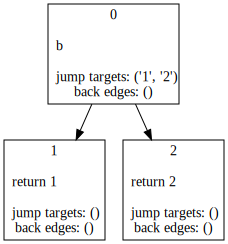

In [36]:
render_scfg_info_notebook(scfg)

We can see from the graph, that it is not closed. Let's restructure.

In [37]:
scfg.restructure()

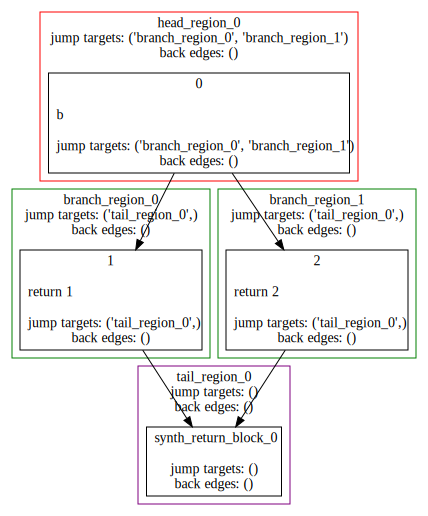

In [38]:
render_scfg_info_notebook(scfg)

As you can see, an additional node was generated and the CFG is now closed. Let's synthesize some Python.

In [39]:
original_ast = unparse_code(multi_return)[0]
transformed_ast  = SCFG2ASTTransformer().transform(original=original_ast, scfg=scfg)
print(ast.unparse(transformed_ast))

def transformed_function(b: int):
    if b:
        __scfg_return_value__ = 1
    else:
        __scfg_return_value__ = 2
    return __scfg_return_value__


In [42]:
transformed_multi_return = compile_ast(transformed_ast)
transformed_multi_return(0), transformed_multi_return(1)

(2, 1)

As you can see, the conversion was fine and we now have a Python program with only a single `return` statement.